In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from statsmodels.formula.api import mnlogit
import seaborn as sns
import statsmodels
from sklearn.metrics import roc_curve, auc
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [16]:
df = pd.read_csv("../data/parsed_data.csv")
df['radiant_win'] = df['radiant_win'].apply(lambda x: 1 if x==True else  0)
print(df.columns)
for i in range(5,25,5):
    sum_r = 0
    sum_d = 0
    for j in range(1,6):
        sum_r+= df["radiant_position_"+str(j)+"_networth_"+str(i)]
        sum_d+= df["dire_position_"+str(j)+"_networth_"+str(i)]
    df["radiant_networth_"+str(i)] = sum_r
    df["dire_networth_"+str(i)] = sum_d


Index(['match_id', 'game_mode', 'game_duration', 'radiant_score', 'dire_score',
       'average_rank', 'radiant_win', 'dire_win', 'winner',
       'radiant_position_4_steam_id',
       ...
       'radiant_networth_lead_15', 'dire_networth_lead_15',
       'radiant_towers_lost_15', 'dire_towers_lost_15', 'radiant_kills_20',
       'dire_kills_20', 'radiant_networth_lead_20', 'dire_networth_lead_20',
       'radiant_towers_lost_20', 'dire_towers_lost_20'],
      dtype='object', length=693)


In [17]:
def generate_columns(include_dire = False, include_rad = True):
    req_columns = ["average_mmr", 'radiant_win']
    for i in range(1, 6):
        req_columns.append("radiant_position_" + str(i) +"_hero" )
        req_columns.append("dire_position_" + str(i) +"_hero" )
        for j in range(5, 25, 5):
            if include_rad:
                req_columns.append("radiant_position_" + str(i) +"_networth_"+str(j))
            if include_dire:
                req_columns.append("dire_position_" + str(i) +"_networth_"+str(j))
    return req_columns

def get_columns_for(team, data_point,range = None,  time=None):
    req_columns = []
    if range:
        for i in range:
            if time:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point+"_"+str(time))
            else:
                req_columns.append(team+"_position_" + str(i) +"_"+data_point)
    else:
        if time:
            return [team+"_"+data_point+"_"+str(time)]
        return [team+"_"+data_point]
    return req_columns


def get_hero_filtered_df(df, num_allowed_heroes):
    dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
    radiant_heroes_cols = get_columns_for( "radiant", "hero", range(1,6))
    hero_cols = dire_heroes_cols + radiant_heroes_cols
    filtered_df = df
    for col in hero_cols:
        filter_keys = filtered_df[col].value_counts()[:num_allowed_heroes].keys()
        filtered_df = filtered_df.loc[filtered_df[col].isin(filter_keys)]
    return filtered_df

def get_formula_for_heroes_and_networth(include_heroes = True, include_networth=[True, False], networth_time=10):
    formula = ""
    if include_heroes:
        dire_heroes_cols = get_columns_for("dire", "hero", range(1,6))
        radiant_heroes_cols = get_columns_for("radiant", "hero", range(1,6))
        cols = dire_heroes_cols + radiant_heroes_cols
        formula +=  cols[0]
        for col in cols[1:]:
            formula = formula + "+" + col
    if len(include_networth) > 0:
        radiant_networth_cols = get_columns_for("radiant", "networth", range(1,6), networth_time)
        dire_net_cols =  get_columns_for("dire", "networth", range(1,6), networth_time)
        cols = []
        if include_networth[0]:
            cols +=  radiant_networth_cols
        if include_networth[1]:
            cols +=  dire_net_cols
        for col in cols:
            formula = formula + "+" + col
    return formula

def get_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + " +col
    return formula

def get_formula_from_cols(cols):
    formula = ""
    if len(cols) > 0:
        formula += cols[0]
    else:
        return formula
    for col in cols:
        formula += " + " +col
    return formula

def get_cat_formula_for(team, data_point,range=None, time=None):
    formula = ""
    cols = get_columns_for(team, data_point, range, time)
    if len(cols) > 0:
        formula += "C("+ cols[0]+")"
    else:
        return formula
    for col in cols:
        formula += " + C(" +col+")"
    return formula

def normalize_cols(df, team, data_point,range=None, time=None):
    cols = get_columns_for(team, data_point, range, time)
    for col in cols:
        df[col]=(df[col]-df[col].mean())/df[col].std()
    return df

def convert_networth_to_ratio(df, team, time):
    cols = get_columns_for(team, "networth", range(1,6), time)
    for col in cols:
        df[col] = df[col]/df[team+"_networth_"+str(time)]
    return df

def exclude_outliers(df, team, data_point,range=None, time=None, width=1.5):
    cols = get_columns_for(team, data_point, range, time)
    normalized = df
    for col in cols:
        normalized = normalized
        new =  (df[col]-df[col].mean())/df[col].std()
        normalized = normalized[np.abs(new) < width]
    return normalized

def exclude_outliers_minmax(df, team, data_point, min, max,range=None, time=None):
    cols = get_columns_for(team, data_point, range, time)
    normalized = df
    for col in cols:
        normalized = normalized[normalized[col] <= max]
        normalized = normalized[ normalized[col] >= min]
    return normalized

In [18]:
def one_hot(df, col):
    one_hot = pd.get_dummies(df[col], prefix=col, dtype=int)
    # Drop column B as it is now encoded
    df = df.drop(col,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

(380, 701)


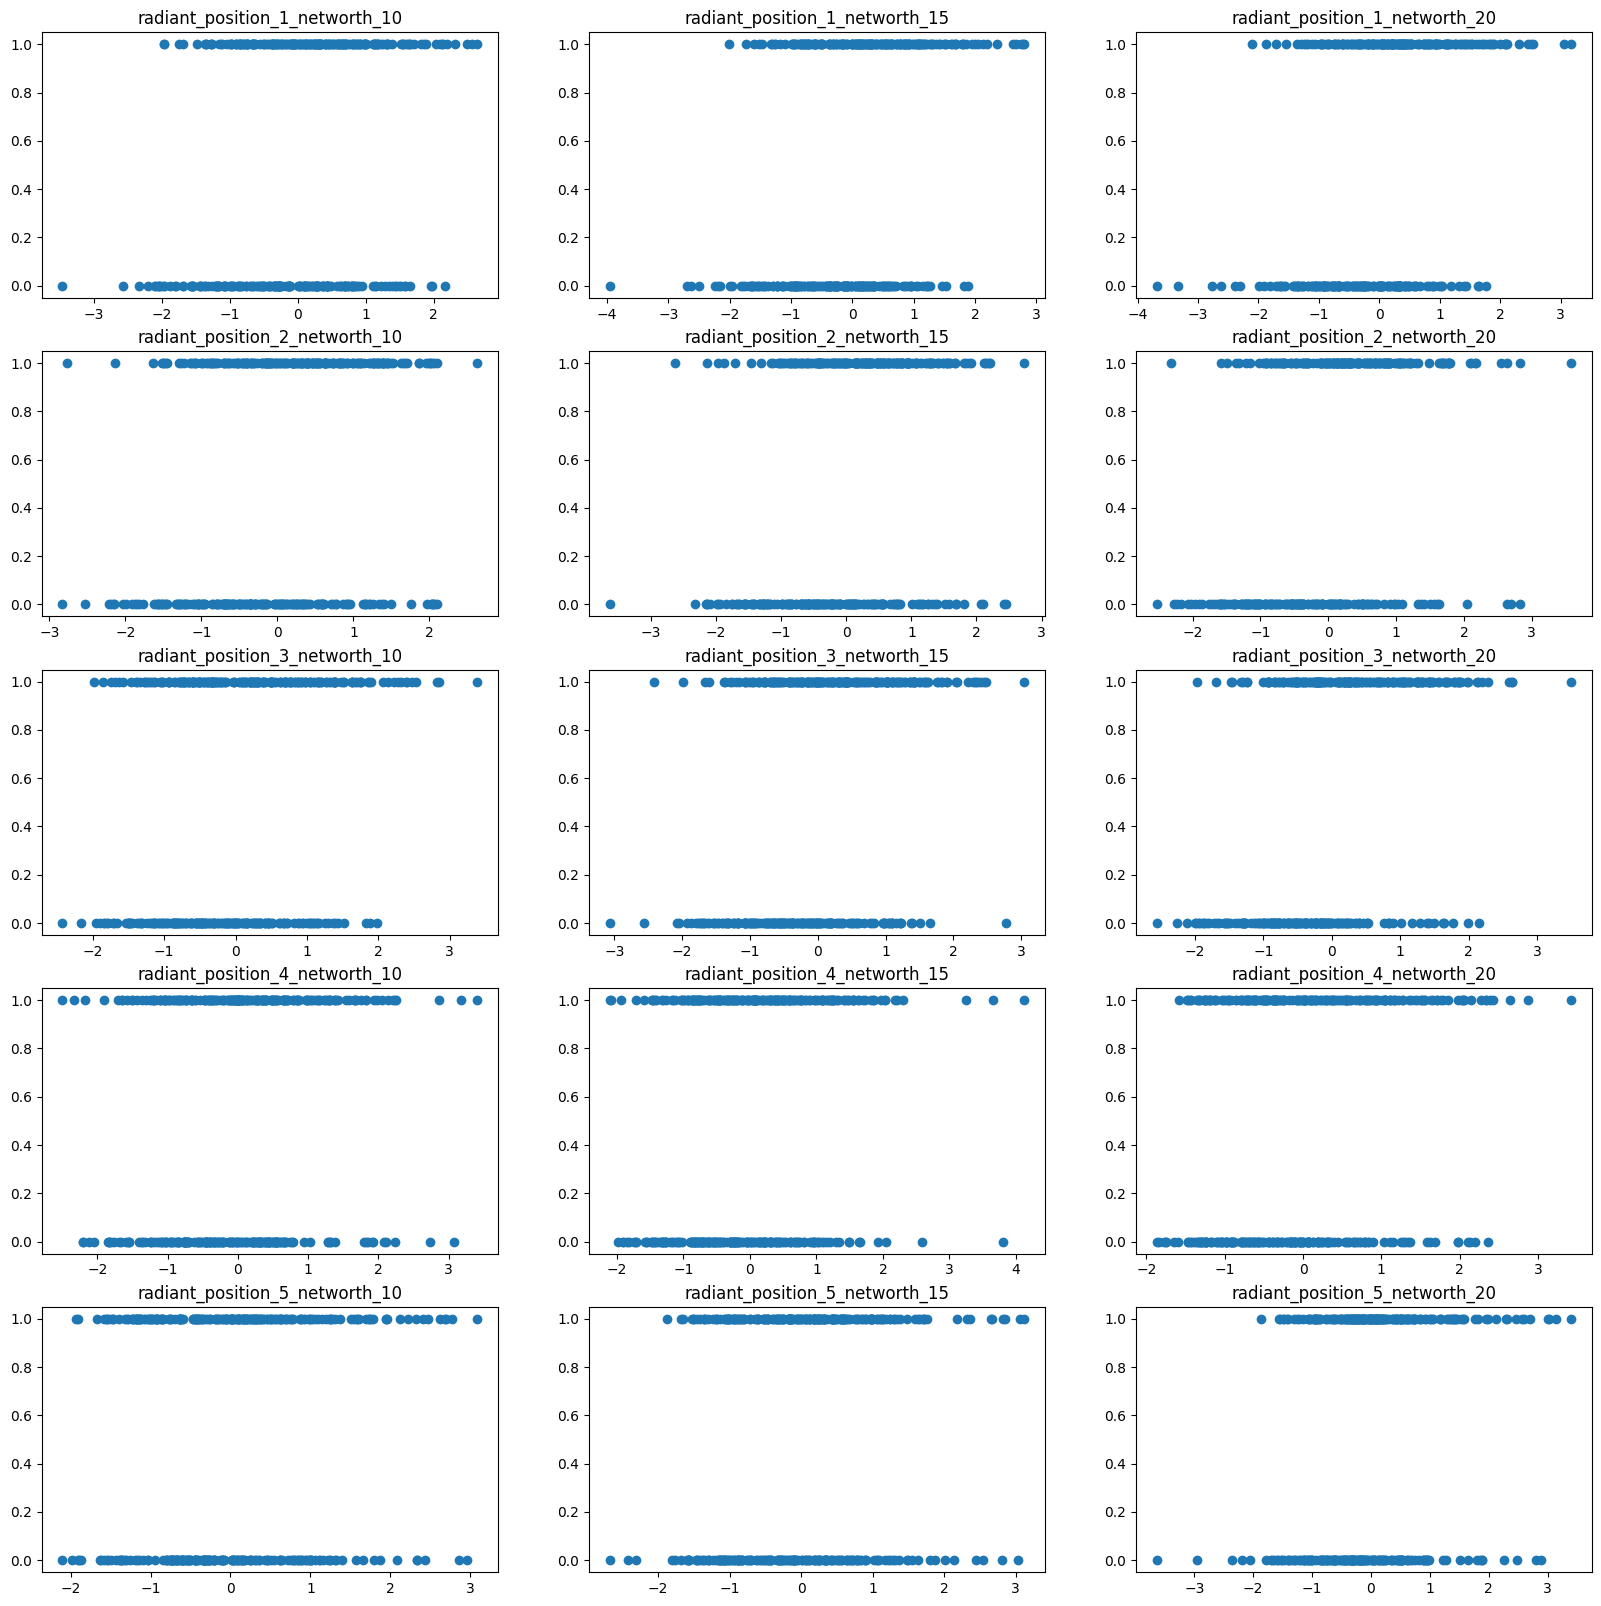

In [19]:
filtered = get_hero_filtered_df(df, 20)

print(filtered.shape)

fig, ax = plt.subplots(5,3)
fig.set_figwidth(20)
fig.set_figheight(20)
for i in range(1, 6):
    for j in range(10, 25, 5):
        col = "radiant_position_"+str(i)+"_networth_"+str(j)
        normalized=(filtered[col]-filtered[col].mean())/filtered[col].std()
        ax[i-1][int(j/5)-2].scatter(normalized, filtered["radiant_win"])
        ax[i-1][int(j/5)-2].set_title(col)


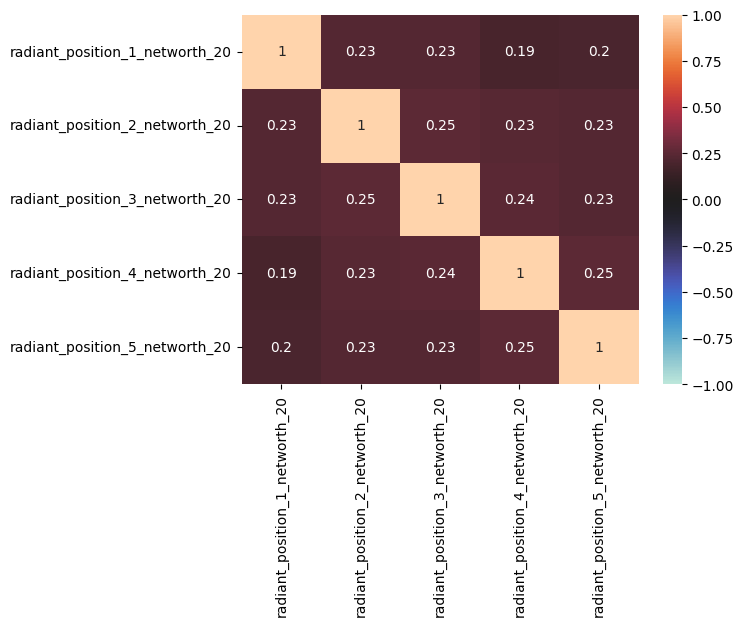

In [20]:
columns = []
columns.extend(get_columns_for("radiant", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "gpm", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "kills", time=20))
#columns.extend(get_columns_for("dire", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "networth", range(1,6), 20))
#columns.extend(get_columns_for("radiant", "networth", time=20))
#columns.extend(get_columns_for("radiant", "xpm", range(1,6), 20))
#columns.extend(get_columns_for("dire", "xpm", range(1,6), 20))
#columns.extend(get_columns_for("dire", "towers_lost", time=20))
#columns.extend(get_columns_for("radiant", "towers_lost", time= 20))
sns.heatmap(df[columns].corr(numeric_only=True),annot=True, center=0, vmax=1, vmin=-1)
x = df


In [31]:
test_time = 20
formula = ""
formula += get_formula_for("radiant", "networth", range(1, 5), time=test_time)
formula += "+"+get_formula_for("dire", "networth", range(1, 5), time=test_time)

#formula += "+"+get_formula_for("radiant", "gpm", range(1, 6), time=test_time)
#formula += "+"+get_formula_for("dire", "gpm", range(1, 6), time=test_time)
#formula += "+"+ get_formula_for("radiant", "networth",time=test_time)
#formula += "+"+ get_formula_for("dire", "networth",time=test_time)
#formula += "+"+get_formula_for("radiant", "hero", range(1, 6))
#formula += "+"+get_cat_formula_for("dire", "hero", range(1, 6))
#formula += "+"+get_cat_formula_for("radiant", "hero", range(1, 6))
#formula += "+"+get_formula_for("radiant", "kills", time=test_time)
#formula += "+"+get_formula_for("dire", "kills", time=test_time)
#formula += "+"+get_formula_for("radiant", "xpm",range(1,6), time=test_time)
#formula += "+"+get_formula_for("dire", "xpm",range(1,6), time=test_time)
#formula +="+"+ get_formula_for("dire", "towers_lost", time=test_time)
#formula +="+"+ get_cat_formula_for("dire", "towers_lost", time=test_time)
#formula += "+"+get_formula_for("radiant", "towers_lost", time=test_time)
#formula +="+"+ get_cat_formula_for("radiant", "towers_lost", time=test_time)

normalized_df = get_hero_filtered_df(df, 40)
normalized_df = exclude_outliers(normalized_df,"radiant","networth_lead", time=test_time, width=1)
normalized_df = exclude_outliers_minmax(normalized_df,"radiant","towers_lost",min=0, max=6, time=test_time)
normalized_df = exclude_outliers_minmax(normalized_df,"dire","towers_lost", min=0, max=6,time=test_time)
#normalized_df = exclude_outliers(normalized_df,"radiant","towers_lost", time=test_time, width=1)
#normalized_df = exclude_outliers(normalized_df,"dire","networth_lead", time=test_time, width=1)
#normalized_df = one_hot(normalized_df, get_columns_for("radiant", "hero", range(1, 6))[0])
normalized_df = convert_networth_to_ratio(normalized_df, "radiant", test_time)
normalized_df = convert_networth_to_ratio(normalized_df, "dire", test_time)
#normalized_df = normalize_cols(normalized_df,"radiant", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant","networth", range(1, 6),time=test_time )
#print(normalized_df[get_columns_for("radiant", "networth", range(1, 6), time=test_time)].head())
normalized_df = normalize_cols(normalized_df,"radiant", "xpm", range(1, 6), time=test_time )
#normalized_df = normalize_cols(normalized_df,"radiant", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "kills", time=test_time )
#normalized_df = normalize_cols(normalized_df,"dire", "networth",range(1, 6),time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "xpm", range(1, 6), time=test_time )
#normalized_df = normalize_cols(normalized_df,"dire", "towers_lost", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "kills", time=test_time )
dota_model = logit(
"radiant_win ~ " + formula,
normalized_df,
)

print(normalized_df.describe())
result  = dota_model.fit()
marginal = result.get_margeff()
print(result.summary(), result.aic)

           match_id  game_duration  radiant_score   dire_score  average_rank  \
count  2.064000e+03    2064.000000    2064.000000  2064.000000        2064.0   
mean   7.469589e+09    2333.859981      36.296027    35.681202          80.0   
std    6.434468e+06     516.941073      11.800986    12.719317           0.0   
min    7.448626e+09    1303.000000       7.000000     5.000000          80.0   
25%    7.466373e+09    1956.000000      28.000000    26.000000          80.0   
50%    7.471712e+09    2265.000000      36.000000    36.000000          80.0   
75%    7.474906e+09    2637.000000      44.000000    45.000000          80.0   
max    7.477122e+09    5219.000000      78.000000    79.000000          80.0   

       radiant_win  radiant_position_4_steam_id  radiant_position_4_hero  \
count  2064.000000                 2.064000e+03              2064.000000   
mean      0.524709                 3.728868e+08                70.655523   
std       0.499510                 3.584929e+08    

## Diagnostic Tests

### Setup

In [39]:
valid_indices = result.resid_pearson.index
test_data = normalized_df[normalized_df.index.isin(valid_indices)]
test_cols = formula.split("+")
test_cols = [x.strip() for x in test_cols]

### Tests

#### Residuals vs probability plot

In [40]:
def plot_resid_prob(result, data, silent=True):
    predicted_probabilities = result.predict(data)
    smoothed = sm.nonparametric.lowess(exog=predicted_probabilities, endog=result.resid_pearson, frac=0.2)
    abs_smoothed_values =  np.abs(smoothed[:, 1])
    if not silent:
        plt.rcParams["figure.figsize"] = (5,5)
        plt.scatter( predicted_probabilities, result.resid_pearson)
        plt.xlabel("Prdicted probability")
        plt.ylabel("Residuals")
        plt.plot(smoothed[:, 0], smoothed[:, 1], c="k")
        plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Add horizontal line at y=0
        plt.legend()
        plt.show()
    return [np.quantile(abs_smoothed_values, 0.75),np.quantile(abs_smoothed_values, 0.50)]

#### Likelyhood Test with Null hypothesis

In [41]:

def compare_loglik_results(result, result_restricted, p_target=0.05, silent=True):
    llf_full = result.llf
    llf_restr = result_restricted.llf
    df_full = result.df_resid
    df_restr = result_restricted.df_resid
    lrdf = (df_restr - df_full)
    lrstat = -2*(llf_restr - llf_full)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    if silent:
        return lr_pvalue
    if lr_pvalue > p_target:
        print("Failed to rejectNull hypothesis, p-value:", lr_pvalue)
    else:
        print("Null hypothesis rejected, p-value:", lr_pvalue)
    return lr_pvalue

def test_full_model_null(result, test_data, p_target, silent=True):
    null_model = logit("radiant_win ~ 1", test_data,)
    null_result = null_model.fit()
    if silent:
        return compare_loglik_results(result, null_result, p_target, silent)
    print("Testing null hypothesis - all parameters are equal to 0")
    return compare_loglik_results(result, null_result, p_target, silent)


#### ROC curve

In [42]:
def plot_roc(result, data, expected_col, silent=True):
    predicted_probabilities = result.predict(data)
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(data[expected_col], predicted_probabilities)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    if silent:
        return roc_auc
    # Plot ROC curve
    plt.figure()
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, label="Random classifier", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc


### Run all tests

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


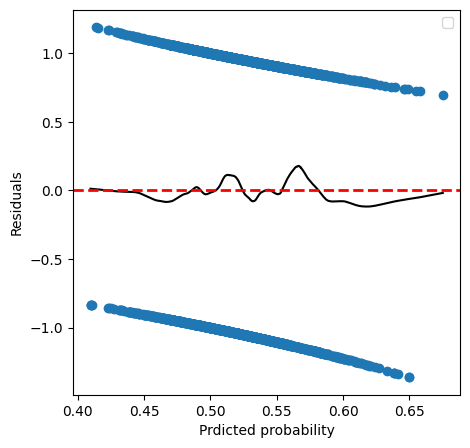

Optimization terminated successfully.
         Current function value: 0.691926
         Iterations 3
Testing null hypothesis - all parameters are equal to 0
Failed to rejectNull hypothesis, p-value: 0.08341530444825015


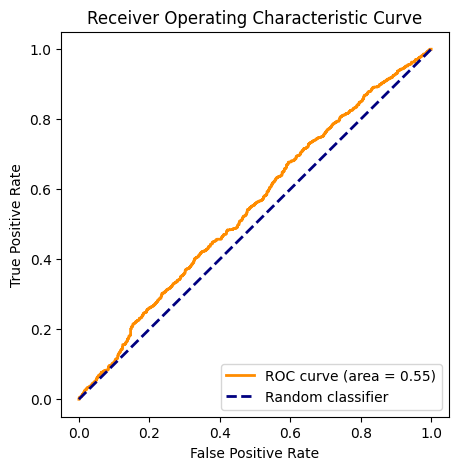

0.5479474747817019

In [43]:
plot_resid_prob(result, test_data, False)
test_full_model_null(result, test_data, 0.05, False)
plot_roc(result,test_data,  "radiant_win", False)

## Automated model selection

### Setup

In [27]:
combo_set = set()
normalized_df = exclude_outliers(df,"radiant","networth_lead", time=test_time, width=1)
normalized_df = exclude_outliers_minmax(normalized_df,"radiant","towers_lost",min=0, max=6, time=test_time)
normalized_df = exclude_outliers_minmax(normalized_df,"dire","towers_lost", min=0, max=6,time=test_time)
normalized_df = normalize_cols(normalized_df,"dire", "networth", time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant","networth", range(1, 6),time=test_time )
normalized_df = normalize_cols(normalized_df,"radiant", "kills", time=test_time )
normalized_df = normalize_cols(normalized_df,"dire", "kills", time=test_time )

fixed_cols = get_columns_for("radiant", "networth", range(1,6), 20)
combo_set.update(get_columns_for("dire", "towers_lost", time=20))
combo_set.update(get_columns_for("dire", "networth", range(1,6), 20))
combo_set.update(get_columns_for("radiant", "towers_lost", time=20))
combo_list = list(combo_set)
li = list(powerset(combo_list))[1:]
result_dict = {"columns":[], "aic":[],"auc":[], "max_resid":[], "75_resid":[],"character_count":[]}

for count in range(20, 80, 5):
    test_df = get_hero_filtered_df(normalized_df, count)
    for _list in li:
        col_as_list = list(_list)
        col_as_list.extend(fixed_cols)
        formula = get_formula_from_cols(col_as_list)
        dota_model = logit(
            "radiant_win ~ " + formula,
            test_df,
        )
        result  = dota_model.fit()
        valid_indices = result.resid_pearson.index
        test_data = normalized_df[normalized_df.index.isin(valid_indices)]
        p_value = test_full_model_null(result, test_data, 0.05)
        if p_value > 0.05:
            continue
        resid = plot_resid_prob(result, test_data)
        auc_res = plot_roc(result,test_data,  "radiant_win")
        result_dict["columns"].append(col_as_list)
        result_dict["character_count"].append(count)
        result_dict["aic"].append(result.aic)
        result_dict["auc"].append(auc_res)
        result_dict["75_resid"].append(resid[0])
        result_dict["max_resid"].append(resid[1])


Optimization terminated successfully.
         Current function value: 0.604345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686666
  

KeyboardInterrupt: 

$E\{Y_i\} = \pi_i = \frac{exp(\beta_0 + \beta_1*X_i)}{1 + exp(\beta_0 + \beta_1*X_i)}$

In [ ]:
result_df = pd.DataFrame(result_dict)

In [ ]:
result_df.describe()

,aic,auc,max_resid,75_resid,character_count
count,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,2792.380630,0.807430,0.323069,0.413329,47.500000
std,1477.673035,0.010284,0.105526,0.129763,17.265928
min,313.624175,0.775843,0.113044,0.228418,20.000000
25%,1547.618685,0.800607,0.243299,0.313543,33.750000
50%,3068.985463,0.807354,0.301851,0.380322,47.500000
75%,4150.816007,0.814571,0.380780,0.473211,61.250000
max,4868.543816,0.833267,0.608833,0.780591,75.000000


In [ ]:
best_set = set()
best_cols_combs = []
for i in range(11):
    count = 20+i*5
    df = result_df[result_df["character_count"] == count]
    df = df.nsmallest(3, '75_resid')
    cols = df["columns"]
    for col in cols:
        best_set.add(" ".join(sorted(col)))
print("\n".join(list(best_set)))


dire_towers_lost_20 radiant_position_1_networth_20 radiant_position_2_networth_20 radiant_position_3_networth_20 radiant_position_4_networth_20 radiant_position_5_networth_20
dire_position_4_networth_20 radiant_position_1_networth_20 radiant_position_2_networth_20 radiant_position_3_networth_20 radiant_position_4_networth_20 radiant_position_5_networth_20
dire_position_2_networth_20 dire_position_3_networth_20 dire_position_4_networth_20 dire_towers_lost_20 radiant_position_1_networth_20 radiant_position_2_networth_20 radiant_position_3_networth_20 radiant_position_4_networth_20 radiant_position_5_networth_20
dire_position_5_networth_20 radiant_position_1_networth_20 radiant_position_2_networth_20 radiant_position_3_networth_20 radiant_position_4_networth_20 radiant_position_5_networth_20
dire_position_1_networth_20 radiant_position_1_networth_20 radiant_position_2_networth_20 radiant_position_3_networth_20 radiant_position_4_networth_20 radiant_position_5_networth_20
dire_position_4_n